In [1]:
# This program performs Monte Carlo Simulation using Geometric Brownian Motion to calculate VaR.

import numpy as np
import pandas as pd
from pandas_datareader import data as web
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import random
from scipy.stats import norm

random.seed(444)

assets = ['FB','AAPL','AMZN','GOOG','NFLX']

# import data
def get_data(stocks, start, end):
    stockData = yf.download(stocks,start,end)['Adj Close']
    df=pd.DataFrame(stockData)
    returns = df.pct_change().dropna()
    covMatrix = returns.cov()
    return returns,covMatrix

def port_mean(df,weights):
    return np.dot(df.mean(), weights)

def portfolioStd(df,weights):
    var=np.dot(weights.T,np.dot(df.cov(),weights))
    return np.sqrt(var)

endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=500)

df_per,covMatrix=get_data(assets, startDate, endDate)

weights=np.array([0.1,0.1,0.1,0.1,0.1])
mean=port_mean(df_per,weights)
std=portfolioStd(df_per,weights)

#Monte Carlo Simulation
mc_sims=1000
T=50
risk_free=0
vol=np.array(df_per.std())

[*********************100%***********************]  5 of 5 completed


In [2]:
#d=(risk_free-0.5*vol**2)*(T/252)
#a=vol*np.sqrt(T/252)
#r=np.random.normal(0,1,size=(T, len(weights)))
#GBM_returns=np.exp(d+a*r)
#Z=(GBM_returns-1)*100


In [3]:



meanM = np.full(shape=(T, len(weights)), fill_value=mean)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(mc_sims):
    d=(risk_free-0.5*vol**2)*(T/252)
    a=vol*np.sqrt(T/252)
    r=np.random.normal(0,1,size=(T, len(weights)))
    GBM_returns=np.exp(d+a*r)
    Z=(GBM_returns-1)*100#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
    






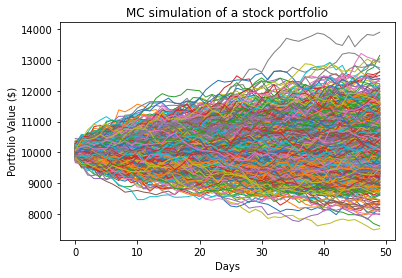

In [4]:
plt.plot(portfolio_sims,linewidth=1)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [5]:
def MonteVaR(series,alpha):
    if isinstance(series,pd.Series):
        return np.percentile(series,alpha)
    else:
        raise TypeError('Expected Pandas Data Series')
        
def MonteCVaR(series,alpha):
    if isinstance(series,pd.Series):
        belowVaR = series <=MonteVaR(series,alpha)
        below=series[belowVaR]
        return np.mean(below)
    else:
        raise TypeError('Expected Pandas Data Series')
        

VaR $1153.9
CVaR $1503.6521642734187


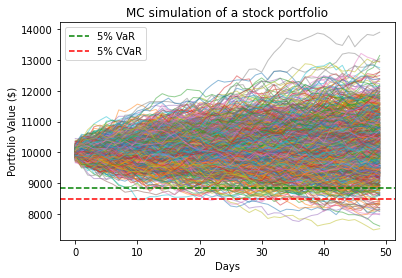

In [6]:
PortfolioReturn=pd.Series(portfolio_sims[-1,:])
alpha=5

VaR = (initialPortfolio - MonteVaR(PortfolioReturn,alpha)).round(2)
CVaR =(initialPortfolio - MonteCVaR(PortfolioReturn,alpha))

print(f'VaR ${VaR}')
print(f'CVaR ${CVaR}')

plt.plot(portfolio_sims,linewidth=1,alpha=0.5)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.axhline(MonteVaR(PortfolioReturn,alpha=5),linestyle='dashed',color='green',linewidth=1.5,label=f"{alpha}% VaR")
plt.axhline(MonteCVaR(PortfolioReturn,alpha=5),linestyle='dashed',color='red',linewidth=1.5,label=f"{alpha}% CVaR")
plt.legend()
plt.title('MC simulation of a stock portfolio')
plt.show()